In [1]:
pip install tensorflow-gpu

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Kiki\\anaconda3\\Lib\\site-packages\\tensorflow\\lite\\experimental\\microfrontend\\python\\ops\\_audio_microfrontend_op.so'
Consider using the `--user` option or check the permissions.



In [1]:
import numpy as np
import pandas as pd
import cv2
import glob as gb
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import seaborn as sns
from keras.utils import np_utils
import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.disable_v2_behavior()
import shap
from tensorflow import keras
from keras import layers,models
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,f1_score, precision_score, recall_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:

s = 48 #format na slikata
emotion_dict = {'anger':0,'disgust':1,'fear':2,'happy':3,'sadness':4,'surprise':5, 'neutral':6}
X = []
y = []
train_dir = 'CK+48/'
for folder in os.listdir(train_dir):
    files = gb.glob(pathname = str(train_dir + folder + '/*.png'))
    for file in files :
        image = cv2.imread(file)
#         --rgb to gray
        image = cv2.resize(image,(s,s))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = np.expand_dims(image, axis=-1)
        image = image.reshape(image.shape[0],image.shape[1],1)
        X.append(list(image))
        y.append(emotion_dict[folder])

X = np.array(X)
y = np.array(y)

In [3]:
def get_label(instance):
    for X,y in emotion_dict.items():
        if instance==y :
            return X

In [4]:
unique, counts = np.unique(y, return_counts=True)

np.asarray((unique, counts)).T

array([[  0, 135],
       [  1, 177],
       [  2,  75],
       [  3, 207],
       [  4,  84],
       [  5, 249],
       [  6, 353]], dtype=int64)

In [5]:
X=X.astype('float32')/255.0

In [6]:
emotion_label = np.array(['anger','disgust','fear', 'happiness', 'sadness', 'surprise', 'neutral'])
# np.array(['anger','disgust','fear', 'happiness', 'sadness', 'surprise','neutral'])

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:ylabel='count'>

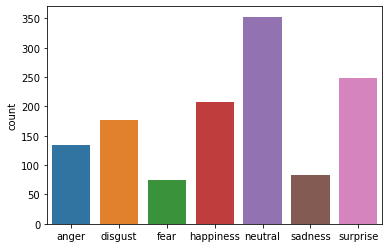

In [7]:
emotion_names=emotion_label[y]
sns.countplot(emotion_names)

In [8]:
X,y = shuffle(X,y, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=0)

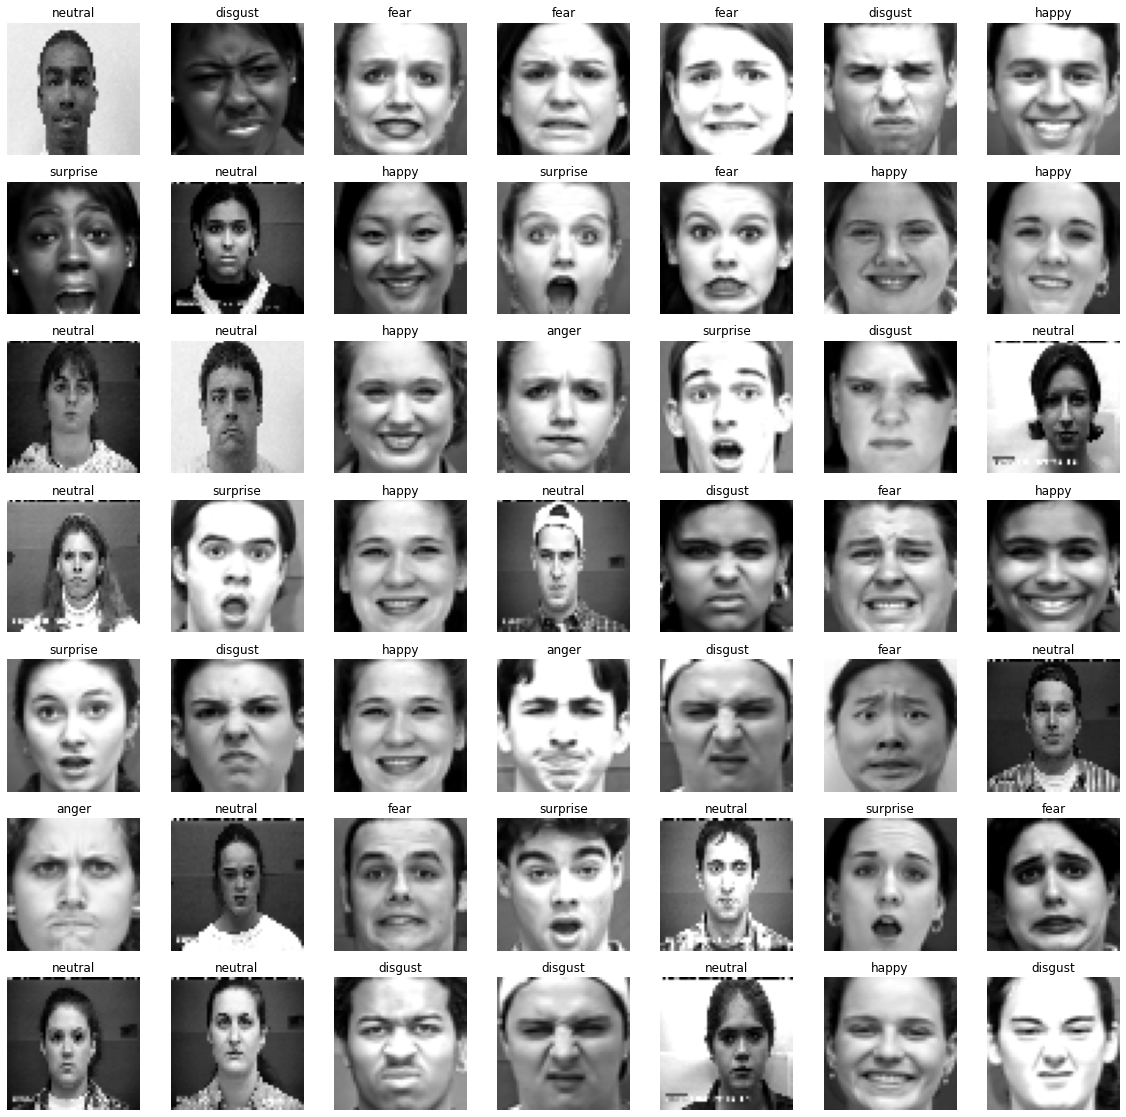

In [9]:
plt.figure(figsize=(20,20))
for n ,i in enumerate(list(np.random.randint(0,len(X_train),49))) :
    plt.subplot(7,7,n+1)
    plt.imshow(X_train[i], cmap = 'gray')
    plt.axis('off')
    plt.title(get_label(y_train[i]))

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range = 30, #0-30
    zoom_range = 0.4,
    horizontal_flip = True,
    rescale=1./255,
    brightness_range=[0.6,1.5],
    fill_mode = 'nearest'
)

# validation_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train,y_train,batch_size=32,shuffle=True)

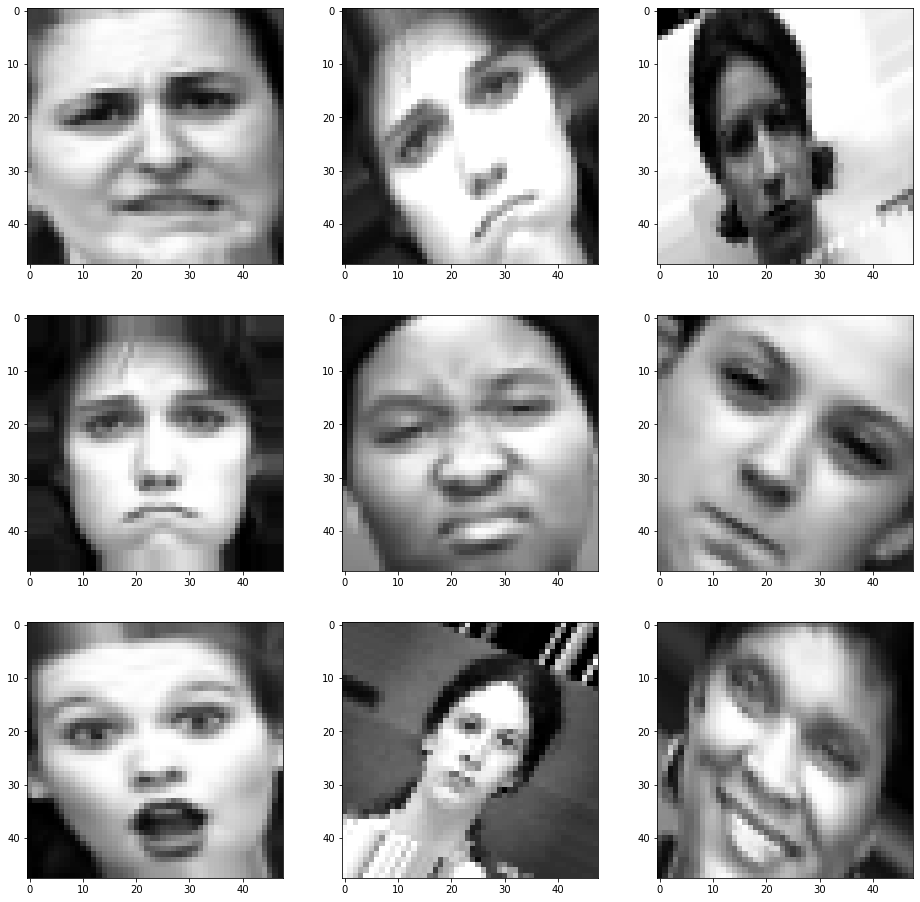

In [11]:
plt.figure(figsize=(16, 16))
for X_batch, y_batch in train_generator:
    # create a grid of 3x3 images
    for i in range(0, 9):
#         print(np.amax(X_batch[i]))
#         print(np.amin(X_batch[i]))
        plt.subplot(3,3,i+1)
        plt.imshow(X_batch[i],cmap='gray')
    # show the plot
    plt.show()
    break

In [144]:
i=layers.Input(shape=X_train[0].shape)

x=layers.Conv2D(64,3,activation='relu',padding='same')(i)
x=layers.MaxPooling2D((2,2))(x)
x=layers.Conv2D(128,(3),activation='relu',padding='same')(x)
x=layers.Conv2D(256,(3,3),activation='relu',padding='same')(x)
x=layers.AveragePooling2D(3)(x)
x=layers.Flatten()(x)
x=layers.Dense(256,activation='relu')(x)
x=layers.Dense(len(set(y)),activation='softmax')(x)

model = keras.Model(inputs=i, outputs=x, name='model_1_da')


In [145]:
model.summary()

Model: "model_1_da"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 conv2d_19 (Conv2D)          (None, 24, 24, 128)       73856     
                                                                 
 conv2d_20 (Conv2D)          (None, 24, 24, 256)       295168    
                                                                 
 average_pooling2d_3 (Averag  (None, 8, 8, 256)        0         
 ePooling2D)                                            

In [146]:
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])


In [149]:
path= 'best_model_data_da.pt'
callback1 = ModelCheckpoint(path,monitor='val_acc',save_best_only=True,mode='max',verbose=1)
callback2 = EarlyStopping(patience=10)
callback_list = [callback1, callback2]
# history_data_augmentated = model.fit(train_generator, 
#                                      batch_size=32 , epochs=20, steps_per_epoch=X_train.shape[0] // 32,
#                                      validation_data = validation_datagen.flow(X_train, y_train, batch_size=8), callbacks=[callback_list], shuffle=True)
history = model.fit(train_generator , epochs=20, validation_data = (X_train, y_train), callbacks = [callback_list],shuffle=True)

Epoch 1/20
34/34 [==============================] - ETA: 0s - batch: 16.5000 - size: 32.0000 - loss: 1.2245 - acc: 0.5340
Epoch 1: val_acc improved from -inf to 0.62500, saving model to best_model_data_da.pt
34/34 [==============================] - 65s 2s/step - batch: 16.5000 - size: 32.0000 - loss: 1.2245 - acc: 0.5340 - val_loss: 0.9642 - val_acc: 0.6250
Epoch 2/20
34/34 [==============================] - ETA: 0s - batch: 16.5000 - size: 32.0000 - loss: 1.0324 - acc: 0.6103
Epoch 2: val_acc improved from 0.62500 to 0.72151, saving model to best_model_data_da.pt
34/34 [==============================] - 63s 2s/step - batch: 16.5000 - size: 32.0000 - loss: 1.0324 - acc: 0.6103 - val_loss: 0.7474 - val_acc: 0.7215
Epoch 3/20
34/34 [==============================] - ETA: 0s - batch: 16.5000 - size: 32.0000 - loss: 0.8801 - acc: 0.6847
Epoch 3: val_acc improved from 0.72151 to 0.77665, saving model to best_model_data_da.pt
34/34 [==============================] - 60s 2s/step - batch: 16.5

In [150]:
model.save('model_1_data.pt')

In [151]:
score = model.evaluate(X_test, y_test)

print("Loss", score[0])
print("Accuracy", score[1])

Loss 0.22891180217266083
Accuracy 0.9114583


We will train the same model on the original dataset without data augmentation.

In [155]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=0)

In [156]:
y_train_encoded = np_utils.to_categorical(y_train, len(set(y)))
y_test_encoded = np_utils.to_categorical(y_test, len(set(y)))
y_val_encoded = np_utils.to_categorical(y_val, len(set(y)))

In [273]:
i=layers.Input(shape=X_train[0].shape)

x=layers.Conv2D(64,3,activation='relu',padding='same')(i)
x=layers.MaxPooling2D((2,2))(x)
x=layers.Conv2D(128,(3),activation='relu',padding='same')(x)
x=layers.Conv2D(256,(3,3),activation='relu',padding='same')(x)
x=layers.AveragePooling2D(3)(x)
x=layers.Flatten()(x)
x=layers.Dense(256,activation='relu')(x)
x=layers.Dense(len(set(y)),activation='softmax')(x)

model = keras.Model(inputs=i, outputs=x, name='model_1')


In [274]:
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])


In [275]:
path= 'best_model_0.pt'
callback1 = ModelCheckpoint(path,monitor='val_acc',save_best_only=True,mode='max',verbose=1)
callback2 = EarlyStopping(patience=10)
callback_list = [callback1, callback2]
train_history_1=model.fit(X_train,y_train_encoded,epochs=20,batch_size=16,callbacks=callback_list,validation_data=[X_val,y_val_encoded])

Train on 924 samples, validate on 164 samples
Epoch 1/20
924/924 [==============================] - ETA: 0s - loss: 1.2031 - acc: 0.5595
Epoch 1: val_acc improved from -inf to 0.79878, saving model to best_model_0.pt
924/924 [==============================] - 51s 56ms/sample - loss: 1.2031 - acc: 0.5595 - val_loss: 0.4936 - val_acc: 0.7988
Epoch 2/20
924/924 [==============================] - ETA: 0s - loss: 0.4757 - acc: 0.8323
Epoch 2: val_acc improved from 0.79878 to 0.89024, saving model to best_model_0.pt
924/924 [==============================] - 47s 50ms/sample - loss: 0.4757 - acc: 0.8323 - val_loss: 0.3315 - val_acc: 0.8902
Epoch 3/20
924/924 [==============================] - ETA: 0s - loss: 0.2738 - acc: 0.9058
Epoch 3: val_acc improved from 0.89024 to 0.92073, saving model to best_model_0.pt
924/924 [==============================] - 46s 50ms/sample - loss: 0.2738 - acc: 0.9058 - val_loss: 0.1778 - val_acc: 0.9207
Epoch 4/20
924/924 [==============================] - ETA: 0

In [277]:
score = model.evaluate(X_test, y_test_encoded)

print("Loss", score[0])
print("Accuracy", score[1])

Loss 0.0029468569312787927
Accuracy 1.0


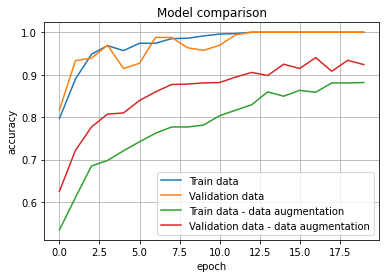

In [169]:
plt.plot(train_history_1.history['acc'],label = 'Train data')
plt.plot(train_history_1.history['val_acc'],label = 'Validation data')

plt.plot(history.history['acc'],label = 'Train data - data augmentation')
plt.plot(history.history['val_acc'],label = 'Validation data - data augmentation')

plt.legend()
plt.grid()
plt.title('Model comparison')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [12]:
model_da=keras.models.load_model('best_model_data_da.pt')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [14]:
model=keras.models.load_model('best_model_0.pt')

In [16]:
def print_confusion_matrix(model_list, labels):
    
    matrices=[]
    for model in model_list:
        y_pred = model.predict(X_test)
        y_pred_cl = np.argmax(y_pred, axis = 1)
        cf_matrix = confusion_matrix(y_test, y_pred_cl)
        matrices.append(cf_matrix)
    
    plt.figure(figsize=(20,8))
    
    for idx,matrix in enumerate(matrices):
        ax = plt.subplot(120 + 1 + idx)

        counts = ["{0:0.0f}".format(value) for value in matrix.flatten()]
        percents = ["{0:.2%}".format(value) for value in matrix.flatten()/np.sum(matrix)]

        labs = [f"{l1}\n{l2}" for l1,l2 in zip (counts,percents)]
        labs = np.asarray(labs).reshape(len(labels),len(labels))

        # sns.heatmap(matrix, annot=True, fmt='g', ax=ax, cmap='Blues') 
        sns.heatmap(matrix, annot=labs, fmt='', ax=ax, cmap='Blues') 
        
        ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
        ax.set_title('Confusion Matrix'); 
        ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
    

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


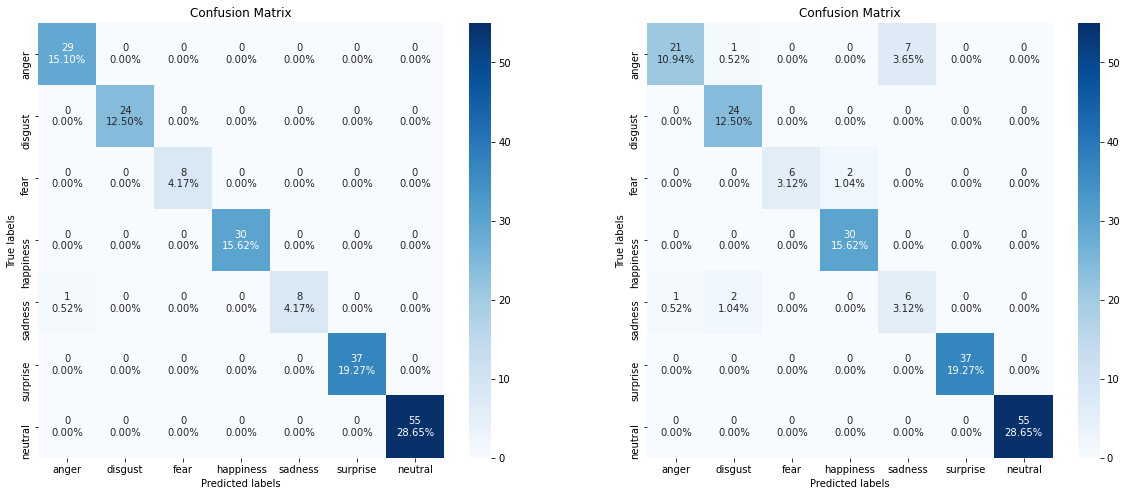

In [17]:
print_confusion_matrix([model,model_da],emotion_label)

In [280]:
def get_metrics(model):
    
    y_pred = model.predict(X_test)
    y_pred_cl = np.argmax(y_pred, axis = 1)
    acc_= accuracy_score(y_pred_cl,y_test)
    recall_= recall_score(y_pred_cl,y_test,average='macro')
    precision_= precision_score(y_pred_cl,y_test,average='macro')
    f1_= f1_score(y_pred_cl,y_test,average='macro')
    scores = [acc_,recall_,precision_,f1_]
    
    return scores


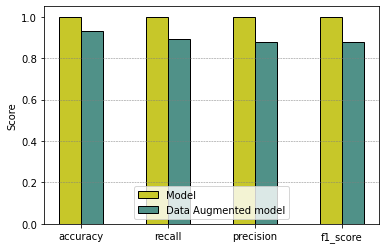

In [312]:
barWidth = 0.25
metrics=['accuracy', 'recall', 'precision', 'f1_score']
l=[x/5 for x in range(1, 5)]

bars1 = get_metrics(model)
bars2 = get_metrics(model_da)

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = '#c7c729', edgecolor = 'black', capsize=7, label='Model')
plt.bar(r2, bars2, width = barWidth, color = '#509188', edgecolor = 'black', capsize=7, label ='Data Augmented model')
 

plt.xticks([r + barWidth/2 for r in range(4)], metrics)
plt.ylabel('Score')
[plt.axhline(y=i,linewidth=0.5, color='gray', linestyle='--') for i in l]
plt.legend(loc='lower center')


plt.show()

# Model explainability

We will print some faces that have high probabilities (above 0.9) and run model explainability on them. 

In [337]:
l=[]
classes=[]
for idx,prob in enumerate(y_pred_data_augm):
    if np.max(prob[5])>0.9:
        l.append(idx)


Happy class

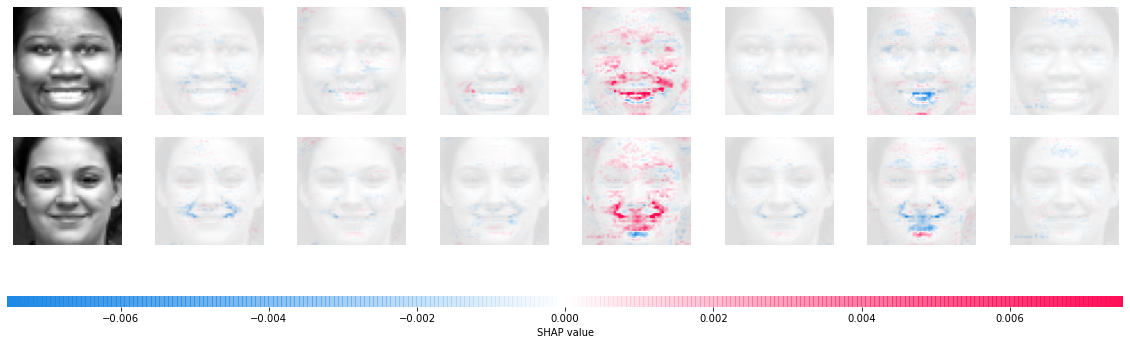

In [233]:
# select a set of background examples to take an expectation over
background = X_train[np.random.choice(X_train.shape[0], 20, replace=False)]

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(X_test[6:8])

# # # plot the feature attributions
shap.image_plot(shap_values, X_test[6:8])

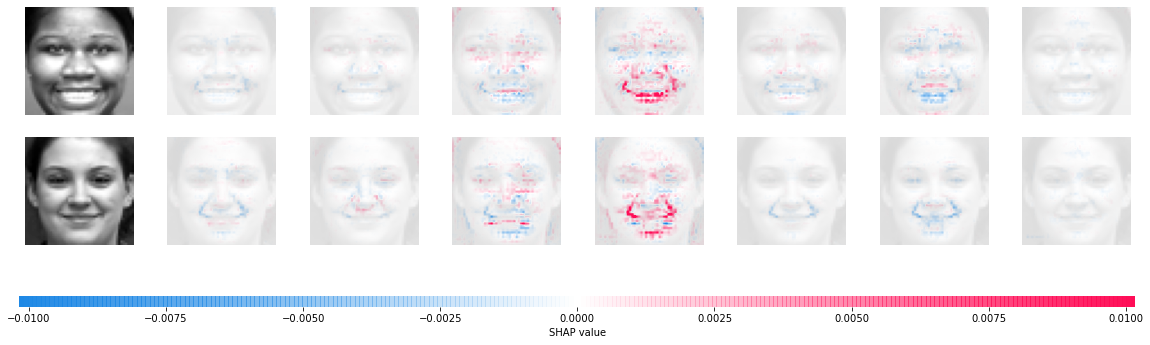

In [234]:
background = X_train[np.random.choice(X_train.shape[0], 20, replace=False)]

# # # explain predictions of the model on four images
e = shap.DeepExplainer(model_da, background)
shap_values = e.shap_values(X_test[6:8])

# # # plot the feature attributions
shap.image_plot(shap_values, X_test[6:8])

Angry class

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


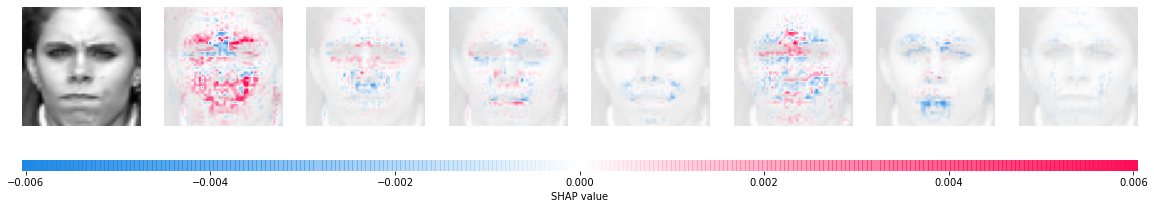

In [328]:
# background = X_train[np.random.choice(X_train.shape[0], 20, replace=False)]

# # # explain predictions of the model on four images
e = shap.DeepExplainer(model_da, background)
# # # ...or pass tensors directly
# # e = shap.DeepExplainer((model_fer.layers[0].input, model_fer.layers[-1].output), background)
shap_values = e.shap_values(X_test[37:38])

# # # plot the feature attributions
shap.image_plot(shap_values, X_test[37:38])

Surprise class

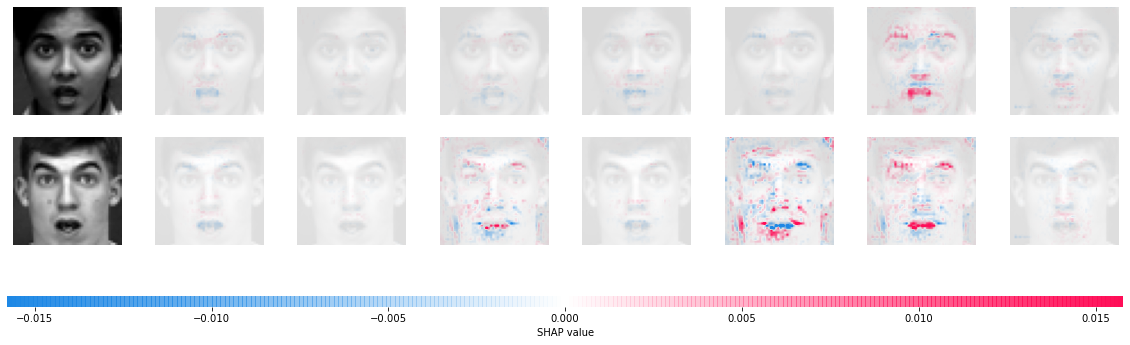

In [331]:
# background = X_train[np.random.choice(X_train.shape[0], 20, replace=False)]

# # # explain predictions of the model on four images
# e = shap.DeepExplainer(model_da, background)
# # # ...or pass tensors directly
# # e = shap.DeepExplainer((model_fer.layers[0].input, model_fer.layers[-1].output), background)
shap_values = e.shap_values(X_test[2:4])

# # # plot the feature attributions
shap.image_plot(shap_values, X_test[2:4])